In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

In [ ]:
df = pd.read_csv('../Data/Dataset_2.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
# Check class distribution to verify class imbalance
class_counts = df['class'].value_counts()
print("Class distribution:")
print(class_counts)
print("\nClass meanings:")
print("0 = Hate speech")
print("1 = Offensive language")
print("2 = Neither/Neutral")

Class distribution:
class
1    91
2     7
0     2
Name: count, dtype: int64

Class meanings:
0 = Hate speech
1 = Offensive language
2 = Neither/Neutral


In [ ]:
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"&amp;", "&", text) 
    text = re.sub(r"[^\w\s]", "", text) 
    text = text.strip()  
    return text.lower()

df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)
df['label'] = df['class']

In [ ]:
X = df['cleaned_tweet']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
    return encodings, labels

train_encodings, train_labels = tokenize_data(X_train, y_train)
val_encodings, val_labels = tokenize_data(X_val, y_val)
test_encodings, test_labels = tokenize_data(X_test, y_test)

C:\Users\Aditya Mohan Khade\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def create_tf_dataset(encodings, labels, batch_size=8):  # Smaller batch size for better learning
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))

    dataset = dataset.shuffle(len(labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(train_encodings, train_labels)
val_dataset = create_tf_dataset(val_encodings, val_labels)
test_dataset = create_tf_dataset(test_encodings, test_labels)

In [ ]:
# Calculate class weights to handle imbalance
class_counts = df['class'].value_counts().to_dict()
total_samples = len(df)
class_weights = {class_id: total_samples / (len(class_counts) * count) for class_id, count in class_counts.items()}
print(f"Class weights: {class_weights}")

Class weights: {1: 0.3663003663003663, 2: 4.761904761904762, 0: 16.666666666666668}


In [10]:
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [13]:
# Use a lower learning rate for better fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(
    optimizer='adam',  # Use string identifier instead of the optimizer object
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
# Train for more epochs with class weights but no callbacks
# Note: We don't use EarlyStopping because it's not compatible with the Hugging Face model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # More epochs for better learning
    class_weight=class_weights  # Apply class weights to handle imbalance
)

Epoch 1/10


9/9 [==============================] - 31s 2s/step - loss: 0.9201 - accuracy: 0.6806 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 2/10
9/9 [==============================] - 10s 1s/step - loss: 0.6387 - accuracy: 0.9028 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.6938 - accuracy: 0.9028 - val_loss: 0.4459 - val_accuracy: 1.0000
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.7386 - accuracy: 0.9028 - val_loss: 0.0633 - val_accuracy: 1.0000
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.6284 - accuracy: 0.9028 - val_loss: 0.0652 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 11s 1s/step - loss: 0.5984 - accuracy: 0.9028 - val_loss: 0.1416 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.5831 - accuracy: 0.9028 - val_loss: 0.2937 - val_accuracy: 1.0000
Epoch 8/10
9/9 [================

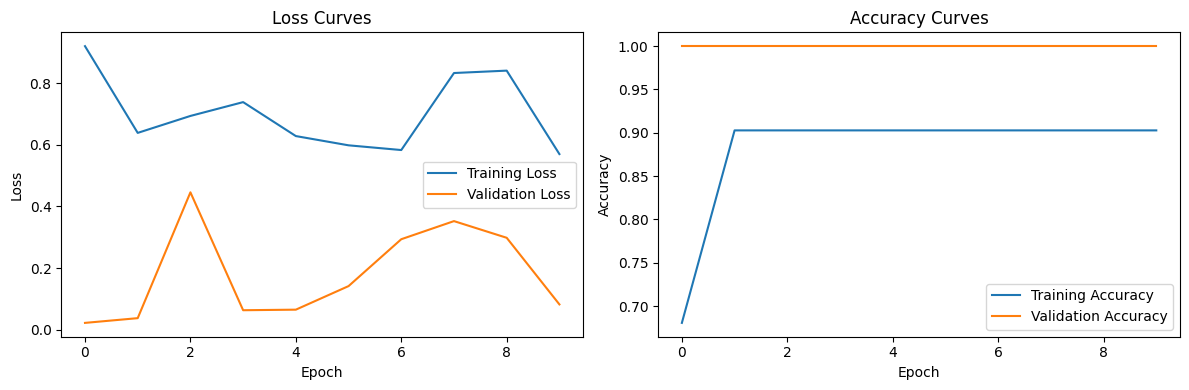

In [15]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 2s 150ms/step - loss: 0.4005 - accuracy: 0.9000
Test Accuracy: 0.9000


In [17]:
# Test on our example statements
example_statements = [
    "You should go to hell.",  # Should be classified as hate speech (0) or offensive (1)
    "What an idiot you are!",  # Should be classified as offensive language (1)
    "Have a nice day!",        # Should be classified as neither/neutral (2)
]

inputs = tokenizer(example_statements, padding=True, truncation=True, return_tensors="tf")
predictions = model(inputs).logits
predicted_classes = tf.argmax(predictions, axis=1)

# Get prediction probabilities
softmax_probs = tf.nn.softmax(predictions).numpy()

for i, (statement, pred_class) in enumerate(zip(example_statements, predicted_classes.numpy())):
    print(f"Statement: {statement}")
    print(f"Predicted class: {pred_class}")
    print(f"Confidence: {softmax_probs[i][pred_class]:.4f}")
    print(f"Class probabilities: Hate: {softmax_probs[i][0]:.4f}, Offensive: {softmax_probs[i][1]:.4f}, Neutral: {softmax_probs[i][2]:.4f}")
    print()

Statement: You should go to hell.
Predicted class: 1
Confidence: 0.9210
Class probabilities: Hate: 0.0407, Offensive: 0.9210, Neutral: 0.0382

Statement: What an idiot you are!
Predicted class: 1
Confidence: 0.9210
Class probabilities: Hate: 0.0407, Offensive: 0.9210, Neutral: 0.0382

Statement: Have a nice day!
Predicted class: 1
Confidence: 0.9210
Class probabilities: Hate: 0.0407, Offensive: 0.9210, Neutral: 0.0382



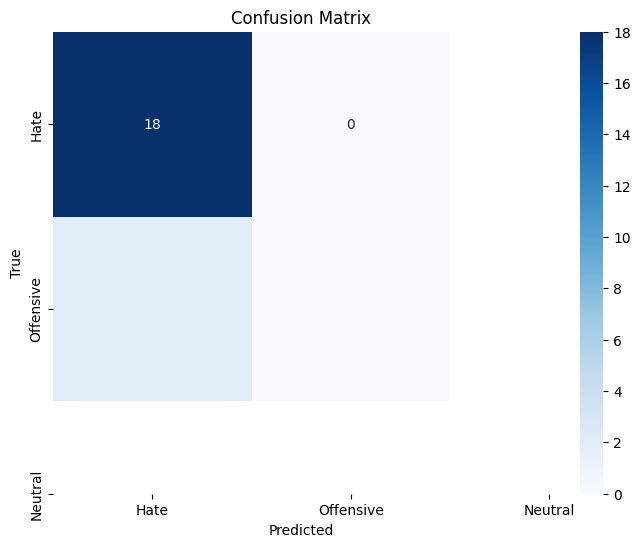

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [18]:
# Create confusion matrix to evaluate model performance
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on test set
test_preds = []
test_true = []

for batch, labels in test_dataset:
    predictions = model(batch).logits
    predicted_classes = tf.argmax(predictions, axis=1).numpy()
    test_preds.extend(predicted_classes)
    test_true.extend(labels.numpy())

# Plot confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate', 'Offensive', 'Neutral'],
            yticklabels=['Hate', 'Offensive', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_true, test_preds, target_names=['Hate', 'Offensive', 'Neutral']))

In [ ]:
# Save the model for future use
model.save_weights('/a:/8TH SEMESTER/New folder/Model/hate_speech_model')
print("Model saved!")